In [ ]:
!pip install SpeechRecognition
!pip install matplotlib
!pip install librosa
!pip install pandas
!pip install tensorflow
!pip install transformers datasets evaluate seqeval
!pip install tf-keras
!pip install tensorflow[and-cuda]
!pip install ipywidgets --upgrade

In [ ]:
import os
import librosa
import numpy as np
import json
import pandas as pd

In [3]:
# import speech_recognition as sr
# recognizer = sr.Recognizer()
# # input a file_path to a .wav file
# # returns the transcribed audio as a string
# # we can use BERT like in the homework to then tokenize/make into array and analyze it
# def getVectorOfWords(file_path):
#     with sr.AudioFile(file_path) as source:
#         audio = recognizer.record(source)
#     try:
#         # print("Transcription:", recognizer.recognize_google(audio))
#         return "" + recognizer.recognize_google(audio)
#     except sr.UnknownValueError:
#         return None

In [4]:
# removes all files from images folder so subsequent runs don't have weird overlaps
# def clearImagesFolder():
#     print("Deleting all data from images folder")
#     directory = os.getcwd() + "/images"
#     for root, dirs, files in os.walk(directory, topdown=False):  # topdown=False to delete files before dirs
#         for file_name in files:
#             file_path = os.path.join(root, file_name)
#             if os.path.isfile(file_path) and file_name.endswith('.png'):
#                 os.remove(file_path)
#                 # print("" + file_path + " has been removed successfully")
#     print("All images removed successfully!")

In [5]:
# import librosa.display
# import matplotlib.pyplot as plt
# # input a file_path to a .wav file
# # returns a png of the spectogram and a filepath to it
# def getSpectogram(file_path, emotion_label):
#     y, sr = librosa.load(file_path, sr=None) # load in the audio file and preserve its sample rate (replace with 16,000 if needed)
    
#     # Compute the spectrogram
#     D = librosa.stft(y)                        # Short-Time Fourier Transform
#     S_db = librosa.amplitude_to_db(abs(D), ref=np.max)  # Convert to decibel scale

#     # Plot and save the spectrogram
#     fig = plt.figure(figsize=(6, 6))                # Set the figure size -- > num pixels will be 100 times this
#     # can change the cmap to "viridis" or "plasma" for different color themes
#     librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="log", cmap="magma")  # Log frequency scale to mimic human audio perception

#     # TODO: at first try hiding as many extra features as possible and compare to when they're included
#     # plt.colorbar(format="%+2.0f dB")           # Add a colorbar
#     # plt.title("Spectrogram")
#     # plt.xlabel("Time (s)")
#     # plt.ylabel("Frequency (Hz)")
#     plt.tight_layout()
    
#     # Save the spectrogram as an image file
#     processed_path = (file_path.split("/")[-1]).split(".")[0]
#     output_image_path = f"./images/{emotion_label}/{processed_path}.png"  # TODO: figure out naming conventions for the file -- either use path or just have a counter that we pass in
#     plt.savefig(output_image_path, dpi=300)    # Save as PNG with high resolution
#     plt.close()                                # Close the figure to free memory
    
#     return output_image_path

In [6]:
# def getTargetEmotionFromCSV(audio_file_name):
#     # parse audio_file_name to get distinguishing file info for CSV lookup
#     dialogueID, utteranceID = (audio_file_name.split(".wav")[0]).split('_')
#     dialogueID, utteranceID = int(dialogueID[3:]), int(utteranceID[3:])
#     csv = pd.read_csv('./train_sent_emo.csv')
#     # Filter the row(s) that satisfy both conditions
#     condition1 = (csv['Dialogue_ID'] == dialogueID)  # First column matches 'dialogueID'
#     condition2 = (csv['Utterance_ID'] == utteranceID)  # Second column matches 'utteranceID'
#     filtered_rows = csv[condition1 & condition2]
#     return filtered_rows['Emotion'].iloc[0]

In [7]:
# def traverse_audio_files(directory="./train_splits_wav"):
#     # clearImagesFolder() # deletes everything from the image folder
#     data = []
    
#     # Traverse and process .wav files
#     print("Starting audio file traversal")
#     iterCount = 0
#     for file_name in os.listdir(directory):
#         # limit the number of loops so this doesn't take THAT long
#         if iterCount >= 3000:
#             break
#         file_path = os.path.join(directory, file_name)
        
#         if os.path.isfile(file_path) and file_name.endswith('.wav'):
#             transcription = getVectorOfWords(file_path)
#             # filter out the audio files that can't get a clear transcription
#             if not transcription:
#                 continue
#             emotion = getTargetEmotionFromCSV(file_name)
#             image_path = getSpectogram(file_path, emotion)
#             data.append({"Transcription": transcription, "Spectogram": image_path, "Emotion": emotion})
#         iterCount += 1
#     df = pd.DataFrame(data)
#     print("Finished creating dataframe and traversing audio files")
#     return df

In [8]:
# df = traverse_audio_files()
# df.to_csv('data3000.csv', index=False)
# print(df)

In [35]:
df = pd.read_csv('data9000.csv')
emotion_labels = df['Emotion'].unique()
print(emotion_labels)
print(df)

['neutral' 'joy' 'fear' 'surprise' 'sadness' 'disgust' 'anger']
                                          Transcription  \
0                                                 Mrs M   
1                                     why did you write   
2                                 I heard what you said   
3                                            for a walk   
4     when did they made me head of purchasing thank...   
...                                                 ...   
3826  play Joey's lovable 2 but the thing about Joey...   
3827                                  what do you think   
3828                                         I guess so   
3829  so I'm just going to go back to talking to my ...   
3830                                               Ross   

                                 Spectogram   Emotion  
0      ./images9000/neutral/dia575_utt1.png   neutral  
1     ./images9000/neutral/dia689_utt12.png   neutral  
2      ./images9000/neutral/dia845_utt8.png   neutral  
3  

In [29]:
##### prepreocessing
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import keras.callbacks
### code following chat

### prep for BERT
from transformers import DistilBertTokenizer
import torch
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize transcriptions
texts = list(df['Transcription'])
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

input_ids = tokens['input_ids']  # Tokenized inputs
attention_masks = tokens['attention_mask']  # Attention masks

### prep for CNN
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

image_paths = list(df['Spectogram'])
images = []

for path in image_paths:
    # Load image
    img = load_img(path, target_size=(128, 128))  # Resize to (128, 128)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    images.append(img_array)

images = np.array(images)  # Shape: (batch_size, 128, 128, 3)

### split the data
from sklearn.model_selection import train_test_split
# Step 1: Split data into training + validation and test sets
x_images_trainval, x_images_test, x_text_trainval, x_text_test, x_attention_trainval, x_attention_test, y_trainval, y_test = train_test_split(
    images, input_ids, attention_masks, labels, test_size=0.15, random_state=42, stratify=labels
)
# Step 2: Further split training + validation into training and validation sets
x_images_train, x_images_val, x_text_train, x_text_val, x_attention_train, x_attention_val, y_train, y_val = train_test_split(
    x_images_trainval, x_text_trainval, x_attention_trainval, y_trainval, test_size=0.15, random_state=42, stratify=y_trainval
)

made it here
waiting to split
split step 1
split step 2


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from transformers import TFDistilBertModel

# BERT Model Wrapper
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.bert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
    
    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, training=training)
        return outputs.last_hidden_state[:, 0, :]  # CLS token embedding

# BERT Branch
text_input = layers.Input(shape=(46,), dtype='int32', name='text_input')  # Adjust shape accordingly
attention_input = layers.Input(shape=(46,), dtype='int32', name='attention_input')
bert_output = BertLayer()([text_input, attention_input])
bert_dense = layers.Dense(128, activation='relu')(bert_output)

# CNN Branch
image_input = layers.Input(shape=(128, 128, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
cnn_dense = layers.Dense(128, activation='relu')(x)

# Combine BERT and CNN Outputs
combined = layers.Concatenate()([bert_dense, cnn_dense])
combined_dense = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(10, activation='softmax')(combined_dense)  # Replace `10` with `num_classes`

# Define and Compile Model
model = Model(inputs=[text_input, attention_input, image_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 63,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_input     │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_2        │ (None, 768)       │          0 │ text_input[0][0], │
│ (BertLayer)         │                   │            │ attention_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     98,432 │ bert_layer_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │  7,372,928 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     16,448 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │        650 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,507,850 (28.64 MB)

 Trainable params: 7,507,850 (28.64 MB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
##### train the model
# Labels
# Custom callback to compute F1 score
# class F1ScoreCallback(tf.keras.callbacks.Callback):
#     def __init__(self, val_data, labels):
#         super().__init__()
#         self.val_data = val_data
#         self.labels = labels

#     def on_epoch_end(self, epoch, logs=None):
#         val_text_input, val_attention_input, val_image_input = self.val_data
#         val_preds = self.model.predict([val_text_input, val_attention_input, val_image_input])
#         val_preds_classes = np.argmax(val_preds, axis=1)
        
#         # Calculate F1 score
#         f1 = f1_score(self.labels, val_preds_classes, average='weighted')  # Weighted F1 score
#         print(f" - val_f1: {f1:.4f}")
#         logs['val_f1'] = f1  # Add F1 score to the logs

# TODO: NEED TO FACTORIZE ALL Y'S (Y_VAL, Y_TRAIN, Y_TEST) // will this change output?
labels = df['Emotion'].factorize()[0]  # Convert emotions to integers


# Train the model
history = model.fit(
    x={'text_input': x_text_train, 'attention_input': x_attention_train, 'image_input': x_images_train},
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(
        {'text_input': x_text_val, 'attention_input': x_attention_val, 'image_input': x_images_val},
        y_val
    )
    # callbacks=[F1ScoreCallback(
    #     val_data=(
    #         x_text_val, x_attention_val, x_images_val), 
    #     labels=y_val
    # )]
)


Epoch 1/10
85/87 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7437 - loss: 0.7244

W0000 00:00:1733377156.202951 1200032 assert_op.cc:38] Ignoring Assert operator functional_2_1/bert_layer_2_1/tf_distil_bert_model_6/distilbert/embeddings/assert_less/Assert/Assert


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

W0000 00:00:1733377158.480871 1200032 assert_op.cc:38] Ignoring Assert operator functional_2_1/bert_layer_2_1/tf_distil_bert_model_6/distilbert/embeddings/assert_less/Assert/Assert


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step


NameError: name 'f1_score' is not defined

Best validation accuracy percentage: 52.96523571014404 %


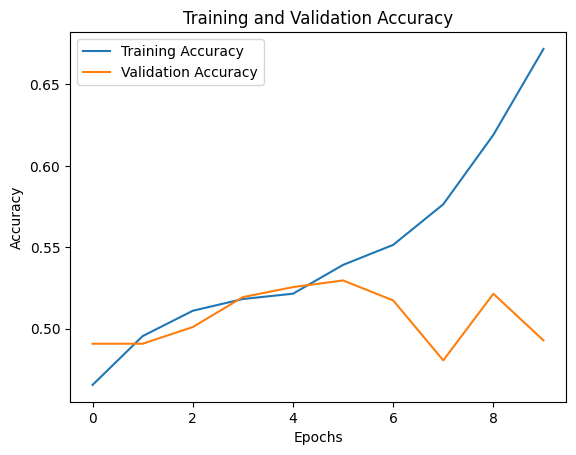

In [32]:
### graphs
print("Best validation accuracy percentage:", max(history.history['val_accuracy']) * 100, "%")

import matplotlib.pyplot as plt
# Plot training vs. validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./plots/train_vs_val_acc', dpi=300)
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


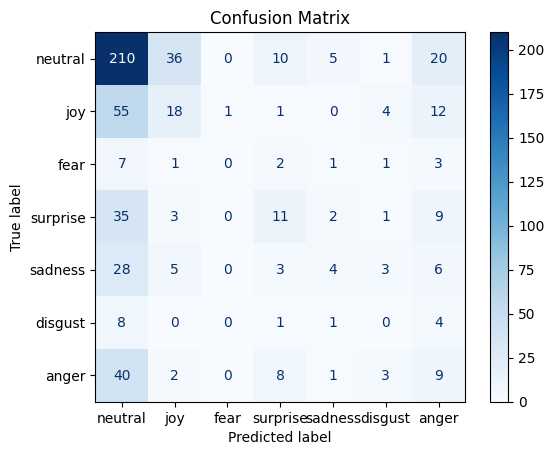

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the test data
y_pred = model.predict({'text_input': x_text_test, 'attention_input': x_attention_test, 'image_input': x_images_test})
y_pred_classes = y_pred.argmax(axis=1)  # Convert softmax outputs to class predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('./plots/confusion_matrix', dpi=300)
plt.show()


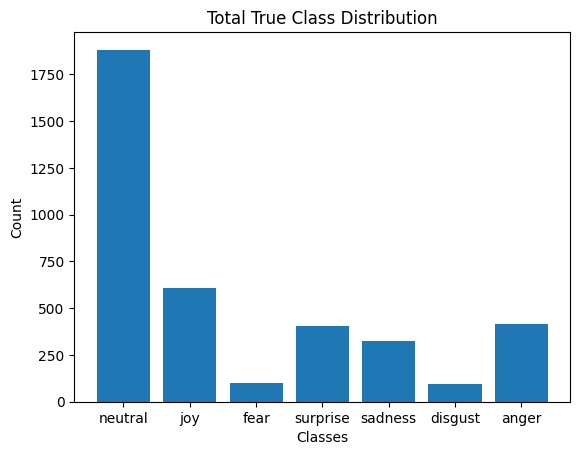

In [44]:
# Combine the true labels from the training, validation, and test sets
y_all_classes = np.concatenate([y_train, y_val, y_test])

# Plot class distribution of all labels
unique, counts = np.unique(y_all_classes, return_counts=True)
plt.bar(unique, counts, tick_label=emotion_labels)  # Use emotion_labels to label your classes
plt.title('Total True Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.savefig('./plots/total_true_class_distribution', dpi=300)
plt.show()


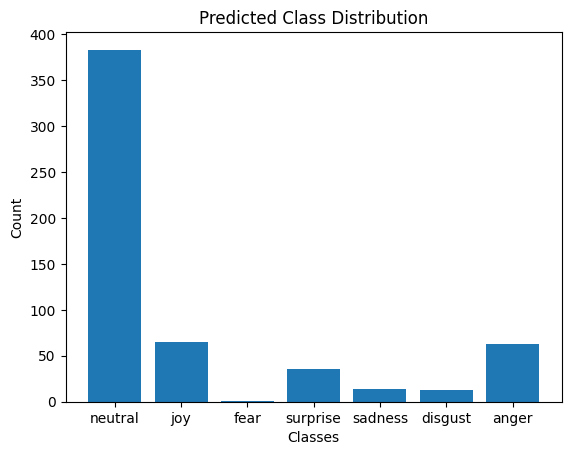

In [39]:
# Get predicted classes
y_pred_classes = y_pred.argmax(axis=1)

# Plot class distribution
unique, counts = np.unique(y_pred_classes, return_counts=True)
plt.bar(unique, counts, tick_label=emotion_labels)
plt.title('Predicted Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.savefig('./plots/pred_class_distribution', dpi=300)
plt.show()


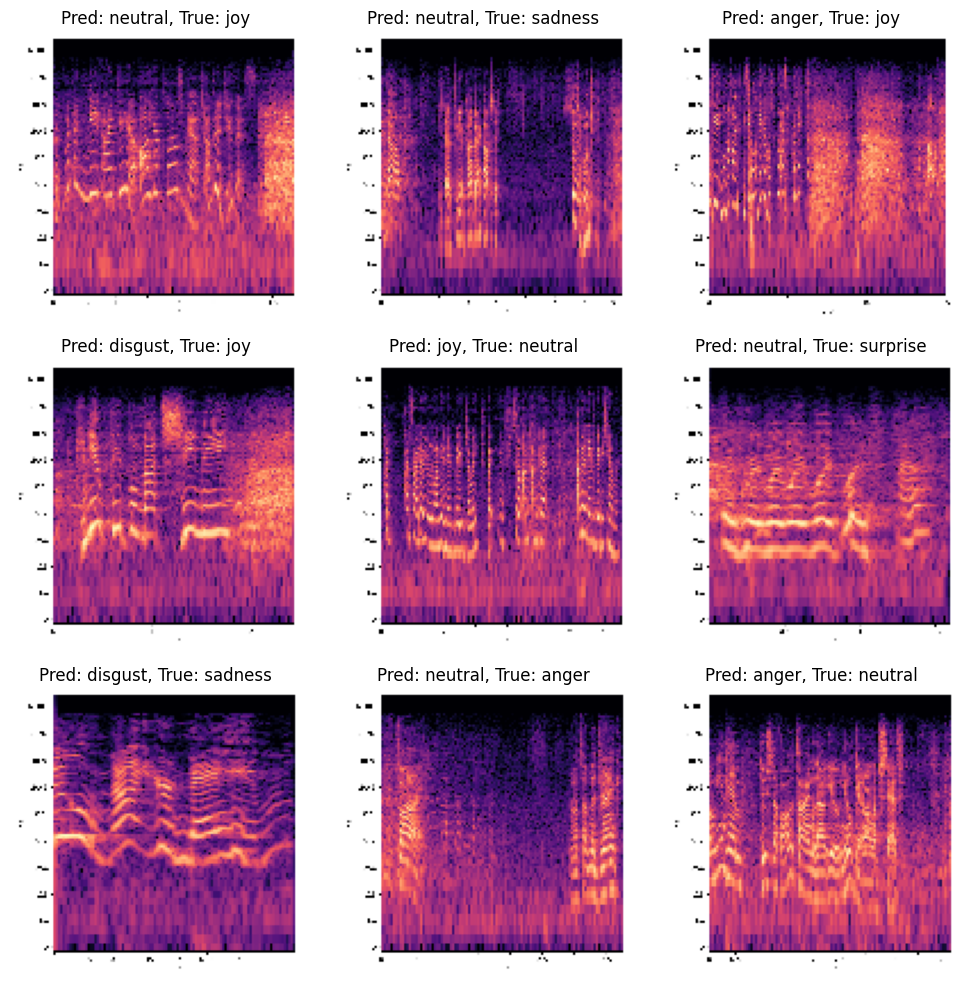

In [43]:
import random

# Identify misclassified examples
misclassified_idx = np.where(y_pred_classes != y_test)[0]

# Plot a few misclassified examples
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random.sample(list(misclassified_idx), 9)):  # Display 9 examples
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_images_test[idx])  # Assuming images are stored in `images_test`
    plt.title(f'Pred: {emotion_labels[y_pred_classes[idx]]}, True: {emotion_labels[y_test[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()
